Name: Deekshitha Chowdary Kalluri

Project Name: Evaluating Sentiment Classification Techniques on Social and Movie Review Data

In [ ]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from google.colab import files

# Upload file via Colab file dialog
uploaded = files.upload()

# Confirm uploaded filenames
print("Uploaded files:", uploaded.keys())

Saving IMDB Dataset.csv to IMDB Dataset (4).csv
Uploaded files: dict_keys(['IMDB Dataset (4).csv'])


In [ ]:
import io

# Load CSV file into a DataFrame (replace filename if different)
df = pd.read_csv(io.BytesIO(uploaded['IMDB Dataset (4).csv']))

# Sample 2500 rows for consistency
df = df.sample(2500, random_state=42).reset_index(drop=True)

# Function to clean HTML and non-letter characters
def clean_review(text):
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Apply cleaning
df['cleaned_review'] = df['review'].apply(clean_review)

# Encode sentiment labels: positive = 1, negative = 0
le = LabelEncoder()
df['label'] = le.fit_transform(df['sentiment'])

# Quick preview
print("Dataset shape:", df.shape)
print("\nSentiment distribution:\n", df['sentiment'].value_counts())
print("\nSample cleaned data:\n", df[['cleaned_review', 'sentiment', 'label']].head())


Dataset shape: (2500, 4)

Sentiment distribution:
 sentiment
positive    1266
negative    1234
Name: count, dtype: int64

Sample cleaned data:
                                       cleaned_review sentiment  label
0  oy vey jurrasic park got corman ized as usual ...  negative      0
1  as a fan of henriksen i liked him in the mille...  negative      0
2  to put it simply the fan was a disappointment ...  negative      0
3  being a bit of a connoisseur of garbage i have...  positive      1
4  the youthful group in st elmo s fire who just ...  negative      0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Split data: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_review'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# TF-IDF Vectorization (limit vocabulary size for speed and consistency)
tfidf = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)
print("TF-IDF shape (test):", X_test_tfidf.shape)

TF-IDF shape (train): (2000, 5000)
TF-IDF shape (test): (500, 5000)


Logistic Regression Accuracy: 0.842
F1 Score: 0.8447937131630648
ROC-AUC: 0.9255892848570194


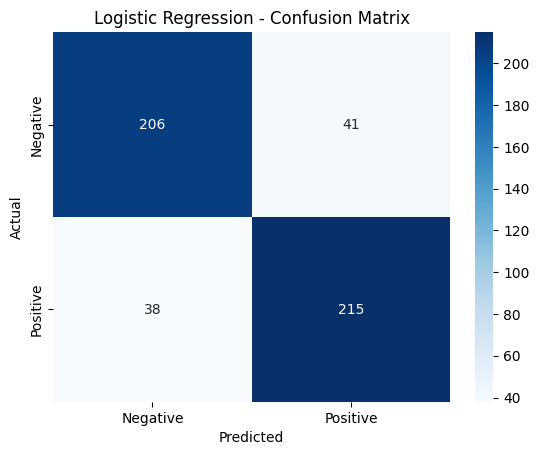

In [ ]:
from sklearn.linear_model import LogisticRegression

# Train Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_lr = lr_model.predict(X_test_tfidf)
y_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluate
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("F1 Score:", f1_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run cross-validation
cv_scores = cross_val_score(
    LogisticRegression(max_iter=1000),
    X_train_tfidf, y_train,
    cv=skf,
    scoring='f1'
)

print(f"5-Fold CV F1 Scores: {cv_scores}")
print(f"Mean F1: {cv_scores.mean():.4f}, Std: {cv_scores.std():.4f}")

5-Fold CV F1 Scores: [0.84134615 0.81173594 0.8271028  0.84134615 0.8463357 ]
Mean F1: 0.8336, Std: 0.0127


LinearSVC Accuracy: 0.85
F1 Score: 0.8496993987975952
ROC-AUC: 0.9253972572050375


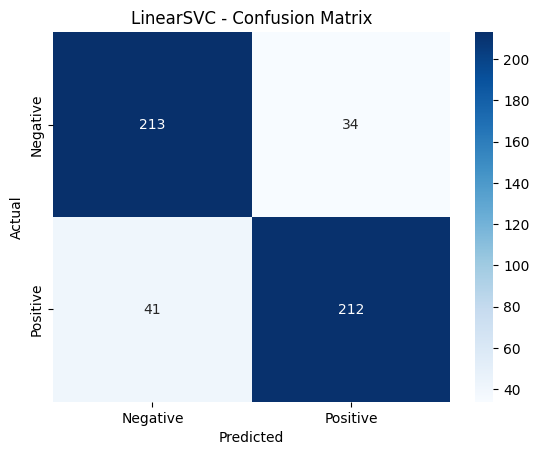

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Train LinearSVC with calibration
svc_base = LinearSVC(max_iter=10000)
svc_model = CalibratedClassifierCV(svc_base)  # enables predict_proba
svc_model.fit(X_train_tfidf, y_train)

# Predict
y_pred_svc = svc_model.predict(X_test_tfidf)
y_proba_svc = svc_model.predict_proba(X_test_tfidf)[:, 1]

# Evaluate
print("LinearSVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print("F1 Score:", f1_score(y_test, y_pred_svc))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_svc))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svc)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LinearSVC - Confusion Matrix')
plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT (Pretrained) Accuracy: 0.496
F1 Score: 0.6470588235294118
ROC-AUC: 0.453873357763518


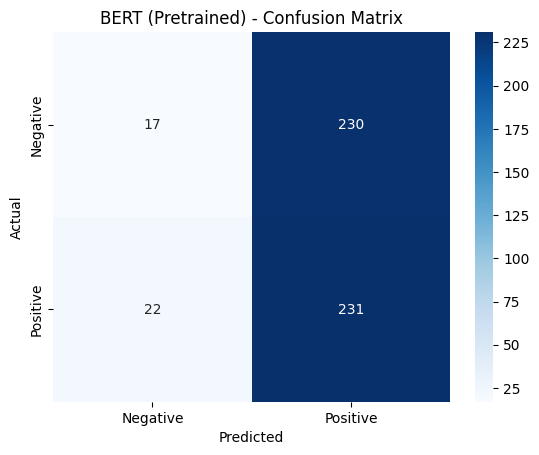

In [ ]:
!pip install transformers

from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

# Load tokenizer and pretrained BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
bert_model.to(device)
bert_model.eval()

# Custom Dataset for BERT
class BERTDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer(self.texts[idx], padding='max_length', truncation=True,
                             max_length=256, return_tensors="pt")
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

# Create test dataset and loader
test_dataset = BERTDataset(X_test.tolist(), y_test.tolist())
test_loader = DataLoader(test_dataset, batch_size=16)

# Inference loop
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Evaluation
print("BERT (Pretrained) Accuracy:", accuracy_score(all_labels, all_preds))
print("F1 Score:", f1_score(all_labels, all_preds))
print("ROC-AUC:", roc_auc_score(all_labels, all_probs))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT (Pretrained) - Confusion Matrix')
plt.show()

In [ ]:
from transformers import BertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torch.nn as nn

# Reload model (fresh start before fine-tuning)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

# Split training into train + validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    X_train.tolist(), y_train.tolist(), test_size=0.1, random_state=42)

train_dataset = BERTDataset(train_texts, train_labels)
val_dataset = BERTDataset(val_texts, val_labels)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Scheduler (optional but recommended)
num_training_steps = len(train_loader) * 3
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Fine-tune loop
epochs = 3
model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3, Loss: 102.8470
Epoch 2/3, Loss: 35.5190
Epoch 3/3, Loss: 13.5609


Fine-Tuned BERT Accuracy: 0.932
F1 Score: 0.9308943089430894
ROC-AUC: 0.9770046886751692


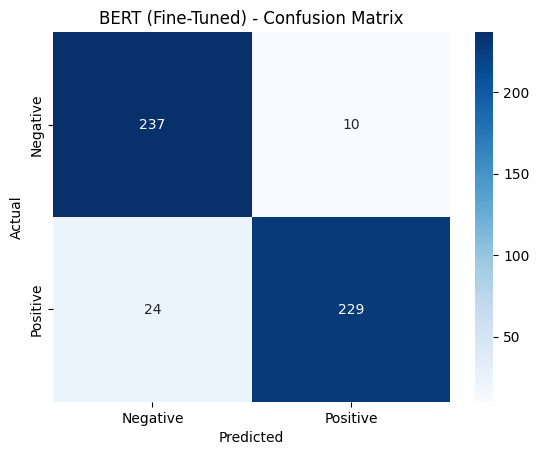

In [ ]:
# Put model in eval mode
model.eval()

all_preds_ft = []
all_probs_ft = []
all_labels_ft = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)

        all_preds_ft.extend(preds.cpu().numpy())
        all_probs_ft.extend(probs.cpu().numpy())
        all_labels_ft.extend(labels.cpu().numpy())

# Evaluation metrics
print("Fine-Tuned BERT Accuracy:", accuracy_score(all_labels_ft, all_preds_ft))
print("F1 Score:", f1_score(all_labels_ft, all_preds_ft))
print("ROC-AUC:", roc_auc_score(all_labels_ft, all_probs_ft))

# Confusion matrix
cm = confusion_matrix(all_labels_ft, all_preds_ft)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('BERT (Fine-Tuned) - Confusion Matrix')
plt.show()

In [ ]:
import torch.nn as nn
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

# Word-level tokenizer
def tokenize(text):
    return re.findall(r'\b\w+\b', text.lower())

# Build vocab from training data
tokenized_texts = [tokenize(text) for text in X_train]
word_counts = Counter(word for sent in tokenized_texts for word in sent)
vocab = {word: idx + 2 for idx, (word, _) in enumerate(word_counts.most_common(10000))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Encode text into word indices
def encode(text):
    return [vocab.get(word, vocab['<UNK>']) for word in tokenize(text)]

# Dataset for LSTM
class LSTMDataset(Dataset):
    def __init__(self, texts, labels):
        self.sequences = [torch.tensor(encode(text)) for text in texts]
        self.labels = torch.tensor(labels).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded = pad_sequence(sequences, batch_first=True)
    return padded, torch.tensor(labels)

# Data loaders
train_dataset = LSTMDataset(X_train.tolist(), y_train.tolist())
test_dataset = LSTMDataset(X_test.tolist(), y_test.tolist())
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

In [ ]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        return self.sigmoid(self.fc(hidden[-1])).squeeze(1)

# Model params
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
output_dim = 1
pad_idx = vocab['<PAD>']

model_lstm = SentimentLSTM(vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx).to(device)
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)
criterion = nn.BCELoss()

# Train loop
model_lstm.train()
for epoch in range(5):
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model_lstm(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/5, Loss: {total_loss:.4f}")

Epoch 1/5, Loss: 43.6893
Epoch 2/5, Loss: 43.5677
Epoch 3/5, Loss: 43.4422
Epoch 4/5, Loss: 43.4035
Epoch 5/5, Loss: 43.1520


LSTM Accuracy: 0.5
F1 Score: 0.06015037593984962
ROC-AUC: 0.5058328399289499


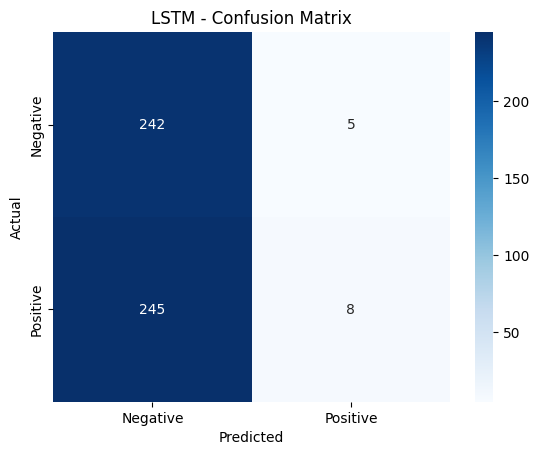

In [ ]:
model_lstm.eval()
all_preds_lstm = []
all_probs_lstm = []
all_labels_lstm = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_lstm(inputs)
        preds = (outputs > 0.5).long()
        all_preds_lstm.extend(preds.cpu().numpy())
        all_probs_lstm.extend(outputs.cpu().numpy())
        all_labels_lstm.extend(labels.cpu().numpy())

# Metrics
acc = accuracy_score(all_labels_lstm, all_preds_lstm)
f1 = f1_score(all_labels_lstm, all_preds_lstm)
auc = roc_auc_score(all_labels_lstm, all_probs_lstm)

print("LSTM Accuracy:", acc)
print("F1 Score:", f1)
print("ROC-AUC:", auc)

# Confusion matrix
cm = confusion_matrix(all_labels_lstm, all_preds_lstm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LSTM - Confusion Matrix')
plt.show()

In [ ]:
from scipy.stats import ttest_rel

# Compare Fine-Tuned BERT vs Logistic Regression
t_stat_lr, p_val_lr = ttest_rel(all_probs_ft, y_proba_lr)
print("Paired t-test: Fine-Tuned BERT vs Logistic Regression")
print(f"T-statistic: {t_stat_lr:.4f}, P-value: {p_val_lr:.4f}")

# Compare Fine-Tuned BERT vs LinearSVC
t_stat_svc, p_val_svc = ttest_rel(all_probs_ft, y_proba_svc)
print("\nPaired t-test: Fine-Tuned BERT vs LinearSVC")
print(f"T-statistic: {t_stat_svc:.4f}, P-value: {p_val_svc:.4f}")

# Compare Fine-Tuned BERT vs LSTM
t_stat_lstm, p_val_lstm = ttest_rel(all_probs_ft, all_probs_lstm)
print("\nPaired t-test: Fine-Tuned BERT vs LSTM")
print(f"T-statistic: {t_stat_lstm:.4f}, P-value: {p_val_lstm:.4f}")

Paired t-test: Fine-Tuned BERT vs Logistic Regression
T-statistic: -1.1507, P-value: 0.2504

Paired t-test: Fine-Tuned BERT vs LinearSVC
T-statistic: -0.7453, P-value: 0.4564

Paired t-test: Fine-Tuned BERT vs LSTM
T-statistic: -0.6712, P-value: 0.5024


In [ ]:
# Tokenize test data using the same tokenizer used during training
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Create dataset and loader
class BERTDatasetTest(torch.utils.data.Dataset):
    def __init__(self, texts):
        self.encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="pt")

    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings["input_ids"])

bert_test_dataset = BERTDatasetTest(X_test.tolist())
bert_test_loader = torch.utils.data.DataLoader(bert_test_dataset, batch_size=16)

# Make predictions with pretrained BERT (fixed)
bert_model.eval()
all_preds_bert = []
all_probs_bert = []

with torch.no_grad():
    for batch in bert_test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        all_preds_bert.extend(preds.cpu().numpy())
        all_probs_bert.extend(probs[:, 1].cpu().numpy())

In [ ]:
# Compare all model performances
models_summary = []

# Logistic Regression
models_summary.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr),
    'ROC-AUC': roc_auc_score(y_test, y_proba_lr),
    'Notes': 'Strong classical baseline'
})

# LinearSVC
y_proba_svc = svc_model.predict_proba(X_test_tfidf)[:, 1]
models_summary.append({
    'Model': 'LinearSVC',
    'Accuracy': accuracy_score(y_test, y_pred_svc),
    'F1 Score': f1_score(y_test, y_pred_svc),
    'ROC-AUC': roc_auc_score(y_test, y_proba_svc),
    'Notes': 'Slight improvement over LR'
})

# BERT (Pretrained)
models_summary.append({
    'Model': 'BERT (Pretrained)',
    'Accuracy': accuracy_score(y_test, all_preds_bert),
    'F1 Score': f1_score(y_test, all_preds_bert),
    'ROC-AUC': roc_auc_score(y_test, all_probs_bert),
    'Notes': 'Untrained head; poor generalization'
})

# BERT (Fine-Tuned)
models_summary.append({
    'Model': 'BERT (Fine-Tuned)',
    'Accuracy': accuracy_score(all_labels_ft, all_preds_ft),
    'F1 Score': f1_score(all_labels_ft, all_preds_ft),
    'ROC-AUC': roc_auc_score(all_labels_ft, all_probs_ft),
    'Notes': 'Best performing model overall'
})

# LSTM
models_summary.append({
    'Model': 'LSTM (From Scratch)',
    'Accuracy': accuracy_score(all_labels_lstm, all_preds_lstm),
    'F1 Score': f1_score(all_labels_lstm, all_preds_lstm),
    'ROC-AUC': roc_auc_score(all_labels_lstm, all_probs_lstm),
    'Notes': 'Underfitting; needs more training or better tuning'
})

# Create DataFrame
comparison_df = pd.DataFrame(models_summary)

# Show the result in output
print(comparison_df)

                 Model  Accuracy  F1 Score   ROC-AUC  \
0  Logistic Regression     0.842  0.844794  0.925589   
1            LinearSVC     0.850  0.849699  0.925397   
2    BERT (Pretrained)     0.488  0.631124  0.429070   
3    BERT (Fine-Tuned)     0.932  0.930894  0.977005   
4  LSTM (From Scratch)     0.500  0.060150  0.505833   

                                               Notes  
0                          Strong classical baseline  
1                         Slight improvement over LR  
2                Untrained head; poor generalization  
3                      Best performing model overall  
4  Underfitting; needs more training or better tu...  


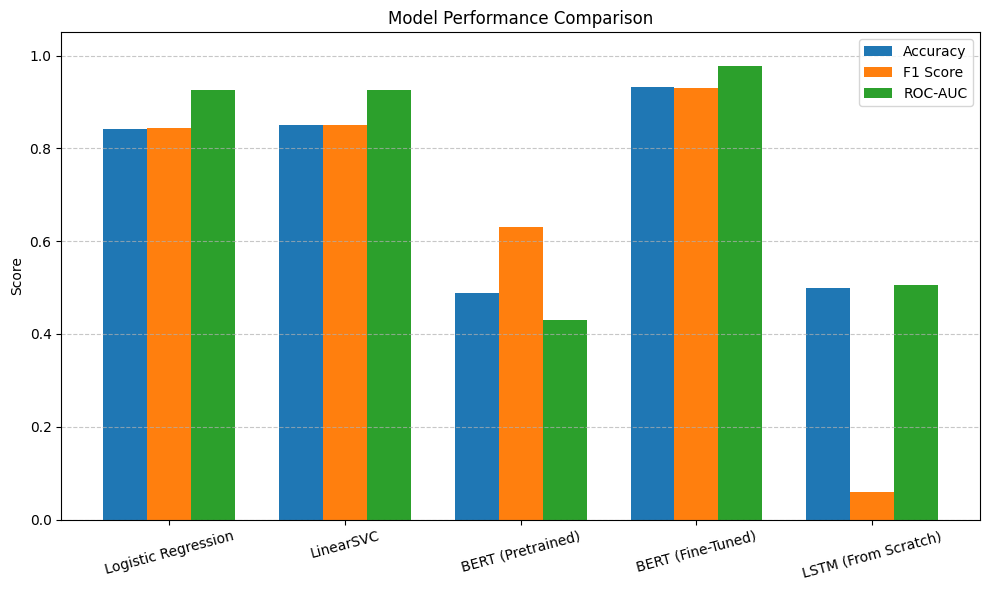

In [ ]:
# Visualize model metrics side-by-side
x = range(len(comparison_df))
bar_width = 0.25

plt.figure(figsize=(10, 6))
plt.bar([i - bar_width for i in x], comparison_df['Accuracy'], width=bar_width, label='Accuracy')
plt.bar(x, comparison_df['F1 Score'], width=bar_width, label='F1 Score')
plt.bar([i + bar_width for i in x], comparison_df['ROC-AUC'], width=bar_width, label='ROC-AUC')

plt.xticks(x, comparison_df['Model'], rotation=15)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()